# Anomaly Detection Evaluation

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import mixture
import json
import sys
import os
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import evaluation
from anomaly_detection import preprocessing as ad_pp
from anomaly_detection import GMM
from anomaly_detection import PCA
from anomaly_detection import results
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
filename = "all_features_(B1)_2017-04-09" #30min, B1
filename = os.path.join('..', 'CSV', filename + ".csv")
B1_30 = pd.read_csv(filename, index_col=0)
B1_30.index = pd.to_datetime(B1_30.index)
B1_30_s = ad_pp.scale_robust(B1_30)

filename = "all_features_(B2)_2017-04-09" #30min, B2
filename = os.path.join('..', 'CSV', filename + ".csv")
B2_30 = pd.read_csv(filename, index_col=0)
B2_30.index = pd.to_datetime(B2_30.index)
B2_30_s = ad_pp.scale_robust(B2_30)

In [29]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
end_date = '2016-10-14 00:00:00.000000'
labeled = client.query_tagged_anomalies(start_date, end_date)
ELB = client.query_elogbook(start_date, end_date)

Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-10-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged
Fetching data for pattern MKI.ELOGBOOK_tagged from 2016-04-16 00:00:00.000000 to 2016-10-14 00:00:00.000000
Fetching data for MKI.ELOGBOOK_tagged


## Evaluation

In [19]:
clf_B1 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B1.fit(B1_30_s)
clf_B2 = mixture.GaussianMixture(n_components=5, covariance_type='tied')
clf_B2.fit(B2_30_s)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [20]:
B1_w_probs = GMM.add_sorted_anomaly_probs(clf_B1, B1_30_s)
B2_w_probs = GMM.add_sorted_anomaly_probs(clf_B2, B2_30_s)

In [21]:
anomaly_sizes = [200, 250, 500, 750, 1000]
segmenter = evaluation.AnomalySegmenter()
evolution_segments_B1 = list(segmenter.segments_generator(B1_w_probs, anomaly_sizes))
evolution_segments_B2 = list(segmenter.segments_generator(B2_w_probs, anomaly_sizes))

Tables below only check with the `anomaly` tag

In [22]:
tables = [evaluation.compare_segmented_with_labeled(segments_B1, segments_B2, labeled)
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

In [23]:
# total_segmented_Bx computes the total number of anomalies in all segments for every step in the evolution
total_segmented_B1 = [sum([s.get_nb_anomalies() for s in segments_B1]) for segments_B1 in evolution_segments_B1]
total_segmented_B2 = [sum([s.get_nb_anomalies() for s in segments_B2]) for segments_B2 in evolution_segments_B2]


nb_segments_B1 = [len(segments_B1) for segments_B1 in evolution_segments_B1]
nb_segments_B2 = [len(segments_B2) for segments_B2 in evolution_segments_B2]

tag_totals = pd.DataFrame(ELB.groupby('VALUE')['TAG'].value_counts())
tag_totals.columns = ['Total_tags']
def count_detected(segments_B1, segments_B2, labels):
    labeled_w_detected = labels.copy()
    labeled_w_detected["detected"] = False
    for label in labeled_w_detected.index:
        ts = labeled_w_detected.loc[label, 'timestamps']
        if labeled_w_detected.loc[label, 'VALUE'] == 'MKI2':
            for segment in segments_B1:
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                       labeled_w_detected.loc[label, 'detected']   = True                                                
        elif labeled_w_detected.loc[label, 'VALUE'] == 'MKI8':
            for segment in segments_B2:
                distance = segment.get_distance_from_ts(ts, 'start')
                if pd.Timedelta(0, unit='h') <= distance <= pd.Timedelta(12, unit='h'):
                       labeled_w_detected.loc[label, 'detected']   = True
                        
    detected = labeled_w_detected[labeled_w_detected['detected'] == True]
    detected_totals = pd.DataFrame(detected.groupby(['VALUE', 'TAG'])['detected'].value_counts())
    detected_totals.index = detected_totals.index.droplevel(2)
    detected_totals.columns = ['Total_detected']
    return detected_totals
# timestamps are not unique => use event id as index
ELB2 = ELB.copy()
ELB2['timestamps'] = ELB2.index
ELB2.index = ELB2['EVENT_ID']
all_detected_totals = [tag_totals.join(count_detected(segments_B1, segments_B2, ELB2))
          for segments_B1, segments_B2 in zip(evolution_segments_B1, evolution_segments_B2)]

In [24]:
for i in range(len(anomaly_sizes)):
    display(tables[i])
    display("Number of anomalies used: {}".format(anomaly_sizes[i]))
    display("Number of anomalies in segments B1: {}".format(total_segmented_B1[i]))
    display("Number of anomalies in segments B2: {}".format(total_segmented_B2[i]))
    display("Total number of segments B1: {}".format(nb_segments_B1[i]))
    display("Total number of segments B2: {}".format(nb_segments_B2[i]))
    detected_totals = all_detected_totals[i]
    detected_totals['recall'] = detected_totals['Total_detected'] / detected_totals['Total_tags'] * 100
    display(detected_totals)

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               2               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               2               1               1   
2016-06-30 21:23:00              16               1               5   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               0   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              48               1               0   
2016-08-02 17:50:00              48               1               0   
2016-08-03 08:05:00               0               0               2   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              18   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2    mean_score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -3579.699635         MKI8  
2016-06-05 17:18:00               1 -22723.064548         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1   -874.928047         MKI2  
2016-06-30 21:23:00               1   -802.930902         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               0      0.000000         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               0   -279.787256         MKI2  
2016-08-02 17:50:00               0   -279.787256         MKI2  
2016-08-03 08:05:00               1   -236.179166         MKI2  
2016-08-04 14:03:41               0      0.000000         MKI2  
2016-08-21 20:00:00               1   -722.092768         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

'Number of anomalies used: 200'

'Number of anomalies in segments B1: 200'

'Number of anomalies in segments B2: 200'

'Total number of segments B1: 43'

'Total number of segments B2: 64'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  info                  26               3   11.538462
      anomaly                9               4   44.444444
      intervention           9               4   44.444444
      fault                  7               1   14.285714
      research               1               1  100.000000
MKI8  info                  22               6   27.272727
      fault                 11               3   27.272727
      intervention          10               2   20.000000
      anomaly                7               3   42.857143
      research               2               1   50.000000

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               1   
2016-06-05 17:18:00               0               0               1   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00               2               1               1   
2016-06-30 21:23:00              24               1              16   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               0   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              54               1               0   
2016-08-02 17:50:00              54               1               0   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               0               0               0   
2016-08-21 20:00:00               0               0              31   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2    mean_score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -2454.870510         MKI8  
2016-06-05 17:18:00               1 -22723.064548         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1   -874.928047         MKI2  
2016-06-30 21:23:00               1   -528.351797         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               0      0.000000         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               0   -258.294916         MKI2  
2016-08-02 17:50:00               0   -258.294916         MKI2  
2016-08-03 08:05:00               0      0.000000         MKI2  
2016-08-04 14:03:41               0      0.000000         MKI2  
2016-08-21 20:00:00               1   -433.111224         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

'Number of anomalies used: 250'

'Number of anomalies in segments B1: 250'

'Number of anomalies in segments B2: 237'

'Total number of segments B1: 45'

'Total number of segments B2: 66'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  info                  26               3   11.538462
      anomaly                9               4   44.444444
      intervention           9               4   44.444444
      fault                  7               1   14.285714
      research               1               1  100.000000
MKI8  info                  22               6   27.272727
      fault                 11               3   27.272727
      intervention          10               2   20.000000
      anomaly                7               3   42.857143
      research               2               1   50.000000

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               3               1               2   
2016-06-05 17:18:00               0               0               2   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00              15               1               3   
2016-06-30 21:23:00              48               1              87   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0               3   
2016-07-31 16:00:00               0               0               0   
2016-08-02 17:28:00              97               1               1   
2016-08-02 17:50:00              97               1               1   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               0               0               2   
2016-08-21 20:00:00               0               0              60   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2    mean_score installation  
timestamps                                                      
2016-05-30 14:00:00               1  -2371.087667         MKI8  
2016-06-05 17:18:00               1 -11357.862220         MKI8  
2016-06-18 19:59:00               0      0.000000         MKI8  
2016-06-19 13:14:00               1   -281.697760         MKI2  
2016-06-30 21:23:00               1   -271.305360         MKI2  
2016-07-14 09:23:00               0      0.000000         MKI8  
2016-07-24 22:19:48               1    -83.894444         MKI2  
2016-07-31 16:00:00               0      0.000000         MKI2  
2016-08-02 17:28:00               1    -87.161772         MKI2  
2016-08-02 17:50:00               1    -87.161772         MKI2  
2016-08-03 08:05:00               0      0.000000         MKI2  
2016-08-04 14:03:41               1      6.532262         MKI2  
2016-08-21 20:00:00               1   -225.297755         MKI8  
2016-08-22 21:30:30               0      0.000000         MKI8  
2016-08-23 06:53:47               0      0.000000         MKI2  
2016-09-02 17:43:00               0      0.000000         MKI8

'Number of anomalies used: 500'

'Number of anomalies in segments B1: 500'

'Number of anomalies in segments B2: 456'

'Total number of segments B1: 55'

'Total number of segments B2: 87'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  info                  26               3   11.538462
      anomaly                9               4   44.444444
      intervention           9               4   44.444444
      fault                  7               1   14.285714
      research               1               1  100.000000
MKI8  info                  22               7   31.818182
      fault                 11               4   36.363636
      intervention          10               2   20.000000
      anomaly                7               3   42.857143
      research               2               1   50.000000

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               4               1               2   
2016-06-05 17:18:00               1               1               3   
2016-06-18 19:59:00               0               0               0   
2016-06-19 13:14:00              34               1               5   
2016-06-30 21:23:00             110               1             113   
2016-07-14 09:23:00               0               0               0   
2016-07-24 22:19:48               0               0              10   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             128               1               1   
2016-08-02 17:50:00             128               1               1   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               1               1               2   
2016-08-21 20:00:00               0               0              69   
2016-08-22 21:30:30               0               0               0   
2016-08-23 06:53:47               0               0               0   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2   mean_score installation  
timestamps                                                     
2016-05-30 14:00:00               1 -1800.954166         MKI8  
2016-06-05 17:18:00               1 -3798.505188         MKI8  
2016-06-18 19:59:00               0     0.000000         MKI8  
2016-06-19 13:14:00               1  -166.492851         MKI2  
2016-06-30 21:23:00               1  -126.894166         MKI2  
2016-07-14 09:23:00               0     0.000000         MKI8  
2016-07-24 22:19:48               1    -9.079582         MKI2  
2016-07-31 16:00:00               1    24.562416         MKI2  
2016-08-02 17:28:00               1   -69.998970         MKI2  
2016-08-02 17:50:00               1   -69.998970         MKI2  
2016-08-03 08:05:00               0     0.000000         MKI2  
2016-08-04 14:03:41               1   -14.741680         MKI2  
2016-08-21 20:00:00               1  -193.227810         MKI8  
2016-08-22 21:30:30               0     0.000000         MKI8  
2016-08-23 06:53:47               0     0.000000         MKI2  
2016-09-02 17:43:00               0     0.000000         MKI8

'Number of anomalies used: 750'

'Number of anomalies in segments B1: 745'

'Number of anomalies in segments B2: 688'

'Total number of segments B1: 77'

'Total number of segments B2: 112'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  info                  26             5.0   19.230769
      anomaly                9             5.0   55.555556
      intervention           9             4.0   44.444444
      fault                  7             1.0   14.285714
      research               1             1.0  100.000000
MKI8  info                  22             9.0   40.909091
      fault                 11             4.0   36.363636
      intervention          10             2.0   20.000000
      anomaly                7             3.0   42.857143
      research               2             NaN         NaN

nb_detected_B1  nb_segments_B1  nb_detected_B2  \
timestamps                                                            
2016-05-30 14:00:00               4               1               4   
2016-06-05 17:18:00               1               1               3   
2016-06-18 19:59:00               0               0               1   
2016-06-19 13:14:00              54               1               5   
2016-06-30 21:23:00             156               1             140   
2016-07-14 09:23:00               2               1               0   
2016-07-24 22:19:48               0               0              16   
2016-07-31 16:00:00               0               0               1   
2016-08-02 17:28:00             176               1               2   
2016-08-02 17:50:00             176               1               2   
2016-08-03 08:05:00               0               0               0   
2016-08-04 14:03:41               1               1               4   
2016-08-21 20:00:00               2               1              93   
2016-08-22 21:30:30               0               0               1   
2016-08-23 06:53:47               0               0               1   
2016-09-02 17:43:00               0               0               0   

                     nb_segments_B2   mean_score installation  
timestamps                                                     
2016-05-30 14:00:00               1 -1753.910250         MKI8  
2016-06-05 17:18:00               1 -3798.505188         MKI8  
2016-06-18 19:59:00               1    29.012665         MKI8  
2016-06-19 13:14:00               1  -158.327503         MKI2  
2016-06-30 21:23:00               1   -89.002226         MKI2  
2016-07-14 09:23:00               0   -11.701046         MKI8  
2016-07-24 22:19:48               1     5.158813         MKI2  
2016-07-31 16:00:00               1    24.562416         MKI2  
2016-08-02 17:28:00               1   -44.568131         MKI2  
2016-08-02 17:50:00               1   -44.568131         MKI2  
2016-08-03 08:05:00               0     0.000000         MKI2  
2016-08-04 14:03:41               1    -8.901690         MKI2  
2016-08-21 20:00:00               1   -77.380075         MKI8  
2016-08-22 21:30:30               1    31.340238         MKI8  
2016-08-23 06:53:47               1    31.340238         MKI2  
2016-09-02 17:43:00               0     0.000000         MKI8

'Number of anomalies used: 1000'

'Number of anomalies in segments B1: 994'

'Number of anomalies in segments B2: 915'

'Total number of segments B1: 86'

'Total number of segments B2: 129'

Total_tags  Total_detected      recall
VALUE TAG                                                 
MKI2  info                  26             5.0   19.230769
      anomaly                9             5.0   55.555556
      intervention           9             5.0   55.555556
      fault                  7             2.0   28.571429
      research               1             1.0  100.000000
MKI8  info                  22            11.0   50.000000
      fault                 11             4.0   36.363636
      intervention          10             1.0   10.000000
      anomaly                7             5.0   71.428571
      research               2             NaN         NaN

## Visualization

In [30]:
labels_B1 = labeled[labeled['VALUE'] == 'MKI2']
labels_B2 = labeled[labeled['VALUE'] == 'MKI8']
ELB_B1 = ELB[ELB['VALUE']== 'MKI2']

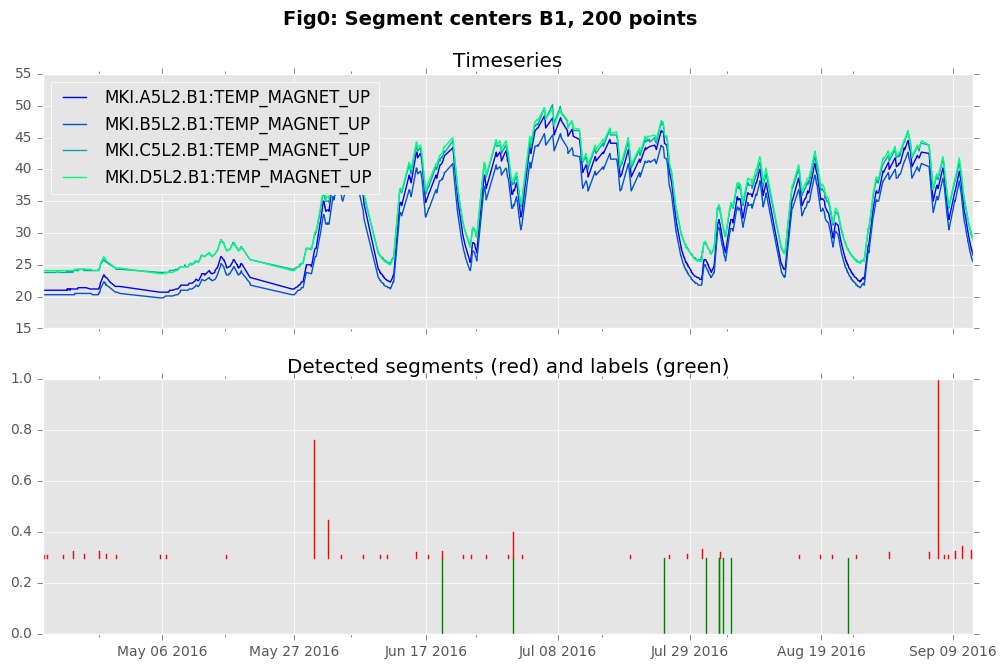

In [31]:
evaluation.plot_segments_series(B1_30, "TEMP_MAGNET_UP", evolution_segments_B1[0], labels_B1, 'Fig0: Segment centers B1, 200 points ')

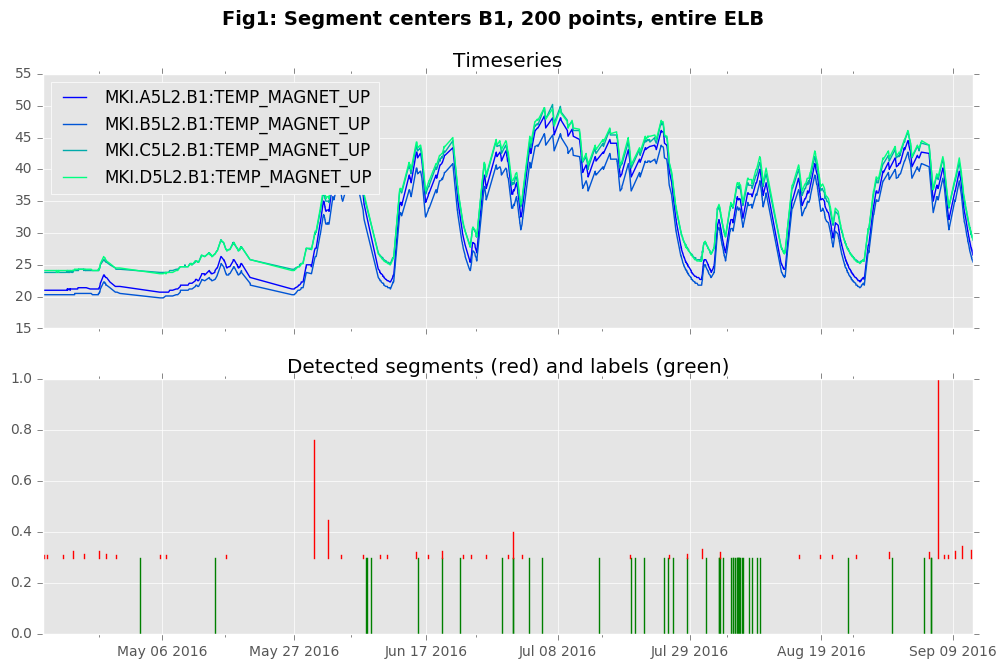

In [32]:
evaluation.plot_segments_series(B1_30, "TEMP_MAGNET_UP", evolution_segments_B1[0], ELB_B1, 'Fig1: Segment centers B1, 200 points, entire ELB')